# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


# 1.EDA

In [2]:
#Load data
to_dt=pd.read_csv("Toronto.csv")

to_dt.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Theft from Vehicle,2008,12,7,16,0,16XX GRANVILLE ST,Central Business District,490419.584,5.457877e+06
1,Theft from Vehicle,2009,4,6,2,0,16XX GRANVILLE ST,Central Business District,490419.584,5.457877e+06
2,Theft from Vehicle,2009,4,21,19,15,16XX GRANVILLE ST,Central Business District,490419.584,5.457877e+06
3,Theft from Vehicle,2009,4,24,18,30,16XX GRANVILLE ST,Central Business District,490419.584,5.457877e+06
4,Theft from Vehicle,2009,5,24,13,30,16XX GRANVILLE ST,Central Business District,490419.584,5.457877e+06


In [3]:
to_dt.shape

(836190, 10)

In [4]:
to_dt.columns

Index(['TYPE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK',
       'NEIGHBOURHOOD', 'X', 'Y'],
      dtype='object')

In [5]:
to_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836190 entries, 0 to 836189
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           836190 non-null  object 
 1   YEAR           836190 non-null  int64  
 2   MONTH          836190 non-null  int64  
 3   DAY            836190 non-null  int64  
 4   HOUR           836190 non-null  int64  
 5   MINUTE         836190 non-null  int64  
 6   HUNDRED_BLOCK  836178 non-null  object 
 7   NEIGHBOURHOOD  836050 non-null  object 
 8   X              836118 non-null  float64
 9   Y              836118 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 63.8+ MB


In [6]:
to_dt.TYPE.value_counts()

Theft from Vehicle                                        234189
Other Theft                                               205014
Mischief                                                   99838
Offence Against a Person                                   72225
Break and Enter Residential/Other                          71089
Break and Enter Commercial                                 45573
Theft of Vehicle                                           43938
Theft of Bicycle                                           35720
Vehicle Collision or Pedestrian Struck (with Injury)       27969
Vehicle Collision or Pedestrian Struck (with Fatality)       334
Homicide                                                     301
Name: TYPE, dtype: int64

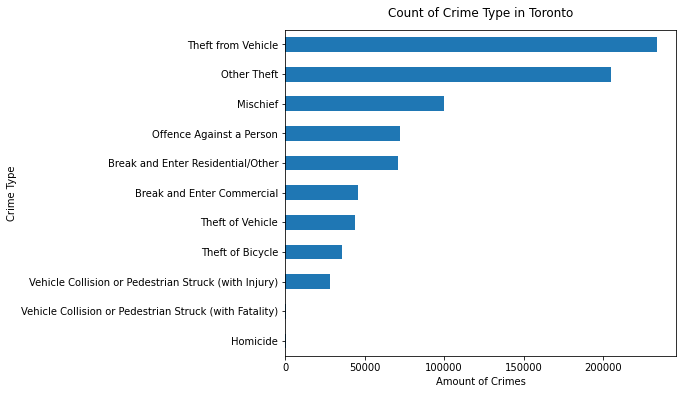

In [7]:
to_dt['TYPE'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(7, 6), rot=0)
plt.title("Count of Crime Type in Toronto", y=1.02)
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')
plt.show()

In [8]:
to_dt.describe()

,YEAR,MONTH,DAY,HOUR,MINUTE,X,Y
count,836190.000000,836190.000000,836190.000000,836190.00000,836190.000000,836118.000000,8.361180e+05
mean,2011.714902,6.492490,15.385330,12.34783,15.773429,449507.083416,4.983482e+06
std,5.845854,3.399089,8.754794,7.45869,18.330313,138558.941402,1.535888e+06
min,2003.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000e+00
25%,2006.000000,4.000000,8.000000,7.00000,0.000000,490183.443000,5.454216e+06
50%,2012.000000,7.000000,15.000000,14.00000,5.000000,491559.696300,5.457156e+06
75%,2017.000000,9.000000,23.000000,18.00000,30.000000,493386.413400,5.458718e+06
max,2022.000000,12.000000,31.000000,23.00000,59.000000,511303.000000,5.512579e+06


array([[<AxesSubplot:title={'center':'YEAR'}>,
        <AxesSubplot:title={'center':'MONTH'}>,
        <AxesSubplot:title={'center':'DAY'}>],
       [<AxesSubplot:title={'center':'HOUR'}>,
        <AxesSubplot:title={'center':'MINUTE'}>,
        <AxesSubplot:title={'center':'X'}>],
       [<AxesSubplot:title={'center':'Y'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

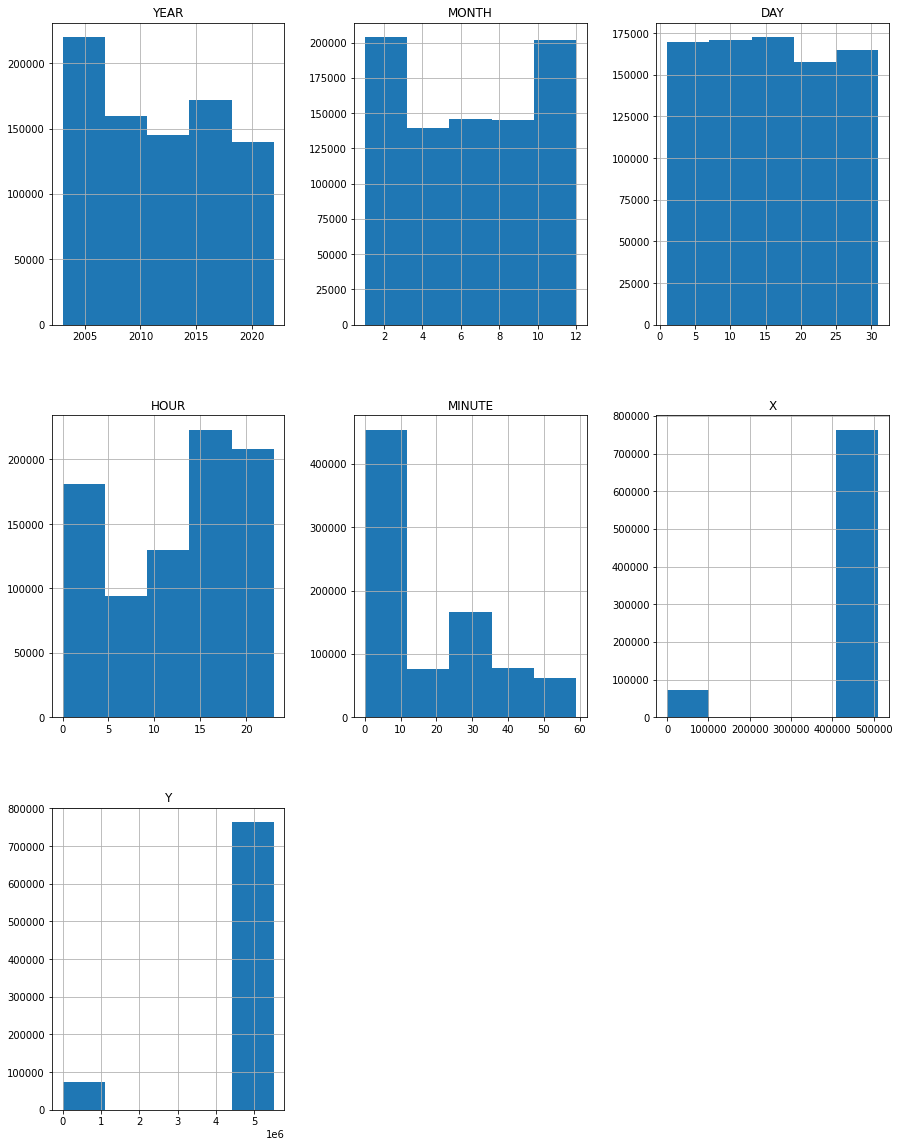

In [9]:
to_dt.hist(bins=5, figsize=(15,20))

In [10]:
cor=to_dt.corr()
cor

,YEAR,MONTH,DAY,HOUR,MINUTE,X,Y
YEAR,1.000000,-0.023050,-0.010768,-0.030907,0.053366,-0.016941,-0.017107
MONTH,-0.023050,1.000000,0.006624,0.003018,-0.005005,0.002857,0.002789
DAY,-0.010768,0.006624,1.000000,0.004567,0.003358,-0.002910,-0.002953
HOUR,-0.030907,0.003018,0.004567,1.000000,0.111064,0.510144,0.510165
MINUTE,0.053366,-0.005005,0.003358,0.111064,1.000000,0.265430,0.265242
X,-0.016941,0.002857,-0.002910,0.510144,0.265430,1.000000,0.999829
Y,-0.017107,0.002789,-0.002953,0.510165,0.265242,0.999829,1.000000


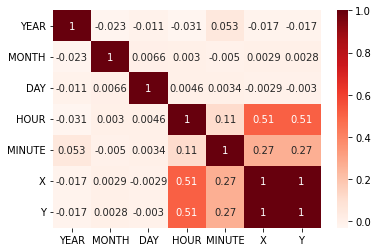

In [11]:
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [12]:
to_dt.duplicated().sum()

29832

# Data processing

In [13]:
# remove duplication 
to_dt.drop_duplicates(keep="first", inplace=True)

In [14]:
to_dt.isnull().value_counts()

TYPE   YEAR   MONTH  DAY    HOUR   MINUTE  HUNDRED_BLOCK  NEIGHBOURHOOD  X      Y    
False  False  False  False  False  False   False          False          False  False    806206
                                                          True           True   True         72
                                                                         False  False        68
                                           True           False          False  False        12
dtype: int64

In [15]:
to_dt.isnull().sum()

TYPE               0
YEAR               0
MONTH              0
DAY                0
HOUR               0
MINUTE             0
HUNDRED_BLOCK     12
NEIGHBOURHOOD    140
X                 72
Y                 72
dtype: int64

In [16]:
#sum of null value in NEIGHBOURHOOD column
to_dt['NEIGHBOURHOOD'].isnull().sum()

140

In [17]:
#drop all missing data
to_dt.dropna(axis=0,inplace=True)

# Feature Engineering

In [18]:
#create dataframe for date
df = pd.DataFrame({'year': to_dt['YEAR'],
                   'month': to_dt['MONTH'],
                   'day': to_dt['DAY']})
date=pd.to_datetime(df[["year", "month", "day"]])

In [19]:
#get all holidays in data 
holidays = calendar().holidays(start='2003-01-01', end='2022-08-19')

In [20]:
#create column for holidays
to_dt["Holiday"] = date.astype("datetime64").isin(holidays)

In [21]:
to_dt[to_dt["Holiday"]==True]

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Holiday
34,Theft from Vehicle,2016,9,5,7,50,16XX GRANVILLE ST,Central Business District,490419.5840,5.457877e+06,True
72,Theft from Vehicle,2014,1,20,5,26,16XX GRANVILLE ST,Central Business District,490427.8293,5.457873e+06,True
75,Theft from Vehicle,2017,1,2,18,0,16XX GRANVILLE ST,Central Business District,490427.8293,5.457873e+06,True
118,Theft from Vehicle,2018,9,3,11,0,16XX HARO ST,West End,490242.0135,5.459620e+06,True
133,Theft from Vehicle,2004,5,31,22,30,16XX HARO ST,West End,490244.6136,5.459631e+06,True
...,...,...,...,...,...,...,...,...,...,...,...
836019,Theft from Vehicle,2018,9,3,17,0,16XX E PENDER ST,Grandview-Woodland,494720.1112,5.458615e+06,True
836054,Theft from Vehicle,2004,12,31,22,0,16XX FRANCES ST,Grandview-Woodland,494721.6096,5.458515e+06,True
836068,Theft from Vehicle,2020,1,1,19,39,16XX FRANCES ST,Grandview-Woodland,494721.6096,5.458515e+06,True
836116,Theft from Vehicle,2019,12,25,10,45,16XX FRANKLIN ST,Grandview-Woodland,494725.2877,5.458826e+06,True


In [22]:
#Create columns for weekend
r=date.apply(lambda x: x)
e=r.dt.day_name()
def weekend(weekday):
    return weekday == "Saturday" or weekday == "Sunday"

to_dt["Weekend"] = e.map(weekend)

In [23]:
to_dt.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Holiday,Weekend
0,Theft from Vehicle,2008,12,7,16,0,16XX GRANVILLE ST,Central Business District,490419.584,5.457877e+06,False,True
1,Theft from Vehicle,2009,4,6,2,0,16XX GRANVILLE ST,Central Business District,490419.584,5.457877e+06,False,False
2,Theft from Vehicle,2009,4,21,19,15,16XX GRANVILLE ST,Central Business District,490419.584,5.457877e+06,False,False
3,Theft from Vehicle,2009,4,24,18,30,16XX GRANVILLE ST,Central Business District,490419.584,5.457877e+06,False,False
4,Theft from Vehicle,2009,5,24,13,30,16XX GRANVILLE ST,Central Business District,490419.584,5.457877e+06,False,True


In [24]:
to_dt[to_dt['Holiday']==True].sum() + to_dt[to_dt['Weekend']==True].sum()

TYPE             Theft from VehicleTheft from VehicleTheft from...
YEAR                                                     514041024
MONTH                                                      1664321
DAY                                                        3932875
HOUR                                                       3198211
MINUTE                                                     4044319
HUNDRED_BLOCK    16XX GRANVILLE ST16XX GRANVILLE ST16XX GRANVIL...
NEIGHBOURHOOD    Central Business DistrictCentral Business Dist...
X                                              118662907816.167206
Y                                             1315630883926.547119
Holiday                                                      21406
Weekend                                                     234123
dtype: object

In [25]:
to_dt['Holiday'].value_counts()

False    784800
True      21406
Name: Holiday, dtype: int64

In [26]:
to_dt['Weekend'].value_counts()

False    572083
True     234123
Name: Weekend, dtype: int64

In [27]:
to_dt['HUNDRED_BLOCK'].value_counts()

OFFSET TO PROTECT PRIVACY    42651
7XX GRANVILLE ST              6857
X NK_LOC ST                   6178
7XX W GEORGIA ST              4777
31XX GRANDVIEW HWY            4233
                             ...  
X STANLEY PARK CSWY CSWY         1
XXXX E 4TH AVE                   1
10XX E 19TH AVE                  1
DAVIE ST / BEACH AVE             1
16XX E 47TH AVE                  1
Name: HUNDRED_BLOCK, Length: 23144, dtype: int64

In [28]:
#put latitude and longitude in one column
'''
to_dt['point'] = list(zip(to_dt.X, to_dt.Y))
to_dt.drop(['X','Y'],axis=1,inplace=True)
to_dt.head()
'''


"\nto_dt['point'] = list(zip(to_dt.X, to_dt.Y))\nto_dt.drop(['X','Y'],axis=1,inplace=True)\nto_dt.head()\n"

# Label Encoding

In [29]:
le = LabelEncoder()
encoder = OneHotEncoder()
encoder_df = pd.DataFrame(encoder.fit_transform(to_dt[['NEIGHBOURHOOD']]).toarray())
final_df = to_dt.join(encoder_df)
del final_df["NEIGHBOURHOOD"]
final_df["TYPE"] = le.fit_transform(final_df["TYPE"])
final_df["Holiday"] = le.fit_transform(final_df["Holiday"])
final_df["Weekend"] = le.fit_transform(final_df["Weekend"])
final_df['HUNDRED_BLOCK']=le.fit_transform(final_df["HUNDRED_BLOCK"])

#to_dt.drop(columns=["TYPE", "Holiday", "Weekend"],Inplace=True)

In [30]:
final_df

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,X,Y,Holiday,...,14,15,16,17,18,19,20,21,22,23
0,6,2008,12,7,16,0,1982,490419.584,5.457877e+06,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,2009,4,6,2,0,1982,490419.584,5.457877e+06,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,2009,4,21,19,15,1982,490419.584,5.457877e+06,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,2009,4,24,18,30,1982,490419.584,5.457877e+06,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,2009,5,24,13,30,1982,490419.584,5.457877e+06,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836185,6,2005,10,22,5,45,1982,490419.584,5.457877e+06,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836186,6,2005,10,23,22,0,1982,490419.584,5.457877e+06,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836187,6,2006,11,30,18,0,1982,490419.584,5.457877e+06,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836188,6,2006,12,31,11,0,1982,490419.584,5.457877e+06,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#drop null values
final_df.dropna(axis=0,inplace=True)
final_df.isnull().sum()

TYPE             0
YEAR             0
MONTH            0
DAY              0
HOUR             0
MINUTE           0
HUNDRED_BLOCK    0
X                0
Y                0
Holiday          0
Weekend          0
0                0
1                0
2                0
3                0
4                0
5                0
6                0
7                0
8                0
9                0
10               0
11               0
12               0
13               0
14               0
15               0
16               0
17               0
18               0
19               0
20               0
21               0
22               0
23               0
dtype: int64

# Model

### Prepare data

In [32]:
x=final_df.drop("TYPE", axis=1)
y=final_df["TYPE"]
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

# Smote

In [33]:
!pip install imblearn


[notice] A new release of pip available: 22.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_oversample, y_oversample = oversample.fit_resample(X_train, y_train)

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


## KNN

In [33]:
r=normalize(x)

X_ttrain, X_ttest, y_ttrain, y_ttest = train_test_split(r,y,test_size=0.3,random_state=1)

In [34]:
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_ttrain, y_ttrain)
y_hat=knn_model.predict(X_ttest)

In [35]:
f1_score(y_ttest,y_hat,average='macro')

0.34749748148312315

In [36]:
accuracy_score(y_ttest,y_hat)

0.4977605242477466

In [37]:
# calculating the accuracy of models with different values of k
mean_acc = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_ttrain,y_ttrain)
    yhat= knn.predict(X_ttest)
    mean_acc[i-1] = accuracy_score(y_ttest, yhat)

mean_acc

array([0.44738413, 0.43834463, 0.46177432, 0.4766927 , 0.48381265,
       0.48787076, 0.49126325, 0.49336316, 0.49597839, 0.49726668,
       0.49776052, 0.49846479, 0.49942671, 0.49997638, 0.50038005,
       0.50054323, 0.50125179, 0.50117878, 0.50136344, 0.50123032])

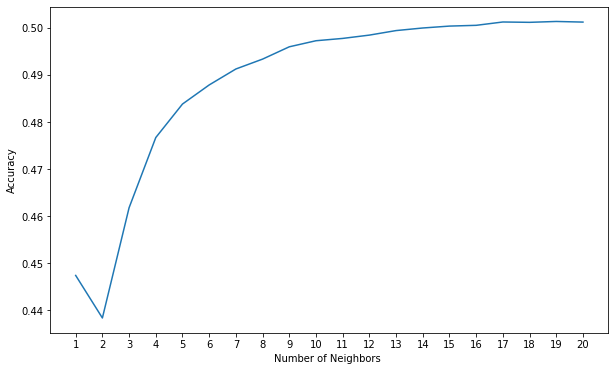

In [38]:
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Hyperparameter Tuning
grid_params = { 'n_neighbors' : [10,13],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs =  RandomizedSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
# fit the model on our train set
g_res = gs.fit(X_ttrain, y_ttrain)

# find the best score
print(g_res.best_score_)
# get the hyperparameters with the best score
print(g_res.best_params_)

In [ ]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 15, weights ='distance',algorithm = 'brute',metric = 'manhattan')
knn.fit(X_ttrain, y_ttrain)
# get a prediction
y_hat = knn.predict(X_ttrain)
y_knn = knn.predict(X_ttest)

In [ ]:
print('Training set accuracy: ', accuracy_score(y_ttrain, y_hat))
print('Test set accuracy: ',accuracy_score(y_ttest, y_knn))
print('Training set f1_score: ', f1_score(y_ttrain, y_hat))
print('Test set f1_score: ',f1_score(y_ttest, y_knn))
print(confusion_matrix(y_ttest, y_knn))
print(classification_report(y_ttest, y_knn))


In [ ]:
scores = cross_val_score(knn, x, y, cv =3)
print('Model accuracy: ',np.mean(scores))

# DecisionTreeClassifier


In [79]:
from sklearn.tree import DecisionTreeClassifier
randmf = DecisionTreeClassifier() 
randmf.fit( X_train, y_train) 
# get a prediction
y_hat = randmf.predict(X_train)
y_randmf = randmf.predict(X_test)
print('Training set accuracy: ', accuracy_score(y_train, y_hat))
print('Test set accuracy: ',accuracy_score(y_test, y_randmf))
print('Training set f1_score: ', f1_score(y_train, y_hat,average='macro'))
print('Test set f1_score: ',f1_score(y_test, y_randmf,average='macro'))
print(confusion_matrix(y_test, y_randmf))
print(classification_report(y_test, y_randmf))

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Training set accuracy:  0.9950768834371635
Test set accuracy:  0.6152696603640705
Training set f1_score:  0.9829556772371482
Test set f1_score:  0.4446150116742594
[[ 5197  1339     0  3071     0  1411  1422   474   511    11   257]
 [ 1409  9468     0  4436     0  1249  2573   579  1305     6   396]
 [    0     0     1     0    87     0     0     0     0     0     0]
 [ 3110  4257     0 12891     0  2497  3830   911  1455    26   872]
 [    0     0   130     0 12593     0     0     0     0     0     0]
 [ 1505  1312     0  2708     0 52128  2230   713   520    18   363]
 [ 1600  2635     0  4125     0  2143 39747  4550  5849    11   471]
 [  503   555     0   850     0   645  4230  2895  1087     2    86]
 [  537  1276     0  1404     0   502  5316  1030  2853     6   206]
 [    8     8     0     8     0    14     4     0     3     0    40]
 [  268   396     0   872     0   419   512   120   252    55  5503]]
              precision    recall  f1-score   support

           0       0.

## RandomForestClassifier

In [40]:
forest_model = RandomForestClassifier(n_estimators=60,max_depth=32,random_state=1)

In [41]:
forest_model.fit(X_train, y_train)
yhat=forest_model.predict(X_test)

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [42]:
f1_score(y_test,yhat,average='macro')

0.4661996624914607

In [43]:
accuracy_score(y_test,yhat)

0.6877359179274006

In [49]:
random_grid = { 
    'n_estimators': [200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
    
    
}
rf=RandomForestClassifier()
#Hyperparameter Tuning
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
                cv = 3, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train, y_train)
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')


C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
16 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\paral

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters:  {'n_estimators': 200, 'max_features': 'auto'}  



In [52]:
#Using the best parameters
randmf = RandomForestClassifier(n_estimators= 200, max_features= 'auto') 
randmf.fit( X_train, y_train) 
# get a prediction
y_hat = randmf.predict(X_train)
y_randmf = randmf.predict(X_test)


C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site

In [54]:
print('Training set accuracy: ', accuracy_score(y_train, y_hat))
print('Test set accuracy: ',accuracy_score(y_test, y_randmf))
print('Training set f1_score: ', f1_score(y_train, y_hat,average='macro'))
print('Test set f1_score: ',f1_score(y_test, y_randmf,average='macro'))
print(confusion_matrix(y_test, y_randmf))
print(classification_report(y_test, y_randmf))

Training set accuracy:  0.9950768834371635
Test set accuracy:  0.6985575457235246
Training set f1_score:  0.9801339487539658
Test set f1_score:  0.47820439061412506
[[ 4548   994     0  3114     0  2441  2221   210   125     0    40]
 [  617 11397     0  3477     0  1877  3536   193   306     0    18]
 [    0     0     0     0    88     0     0     0     0     0     0]
 [ 1531  4120     0 12883     0  4347  5790   222   293     0   663]
 [    0     0    27     0 12696     0     0     0     0     0     0]
 [  338   461     0  1111     0 56061  3186   144    65     0   131]
 [  328   661     0  1018     0  1429 56080   512   791     0   312]
 [  170   226     0   437     0   715  6827  2076   342     0    60]
 [  153   978     0   969     0   527  8415   334  1581     0   173]
 [    3     8     0    11     0    17     6     0     0     0    40]
 [   95   434     0   770     0  1028   663    25    31     2  5349]]
              precision    recall  f1-score   support

           0       0

# Random forest With SMOTE 

In [37]:
#Using the best parameters
randmf = RandomForestClassifier(n_estimators= 200, max_features= 'auto') 
randmf.fit(X_oversample, y_oversample) 
# get a prediction
y_hat = randmf.predict(X_oversample)
y_randmf = randmf.predict(X_test)
print('Training set accuracy: ', accuracy_score(y_oversample, y_hat))
print('Test set accuracy: ',accuracy_score(y_test, y_randmf))
print('Training set f1_score: ', f1_score(y_oversample, y_hat,average='macro'))
print('Test set f1_score: ',f1_score(y_test, y_randmf,average='macro'))
print(confusion_matrix(y_test, y_randmf))
print(classification_report(y_test, y_randmf))

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site

Training set accuracy:  0.9977594056501999
Test set accuracy:  0.6547084816655
Training set f1_score:  0.9977592454495756
Test set f1_score:  0.48517590786641
[[ 6535   941     0  2354     0  1515  1339   562   378     1    68]
 [ 1171 11943     0  2999     0  1276  2085   672  1233     1    41]
 [    0     0     1     0    87     0     0     0     0     0     0]
 [ 3253  4600     0 11683     0  3107  4051  1061  1072     3  1019]
 [    0     0   112     0 12611     0     0     0     0     0     0]
 [ 1522  1119     0  1836     0 52146  2764  1267   415     0   428]
 [ 1270  1301     0  1706     0  1462 43494  5191  6070     1   636]
 [  363   244     0   433     0   349  4038  4383   941     1   101]
 [  331  1074     0   832     0   334  5525   926  3839     0   269]
 [    6    11     0     7     0     9     3     1     2     0    46]
 [  260   463     0   614     0   647   303   124   159     2  5825]]
              precision    recall  f1-score   support

           0       0.44   

## naive_bayes

In [55]:
nav = GaussianNB()
#Train the model using the training sets
nav.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = nav.predict(X_test)

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [56]:
f1_score(y_test,y_pred,average='macro')

0.1913723474092057

In [57]:
accuracy_score(y_test,y_pred)

0.3574873210888619

# xgboost 

In [58]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
ypred = xg.predict(X_test)

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [59]:
f1_score(y_test,ypred,average='macro')

0.4760444738849769

In [60]:
accuracy_score(y_test,ypred)

0.6931424375287181

# Regrouping

In [39]:
final_df[final_df['TYPE']==1]=0
final_df[final_df['TYPE']==8]=7
final_df[final_df['TYPE']==9]=10
final_df[final_df['TYPE']==4]=2

In [40]:
x=final_df.drop("TYPE", axis=1)
y=final_df["TYPE"]
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [41]:
oversample = SMOTE()
X_oversample, y_oversample = oversample.fit_resample(X_train, y_train)

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


## RandomForestClassifier

In [66]:
forest_model = RandomForestClassifier(n_estimators=200)
forest_model.fit(X_train, y_train)
yhat=forest_model.predict(X_test)
f1_score(y_test,yhat,average='macro')
accuracy_score(y_test,yhat)

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.8168482438473463

In [67]:
#Using the best parameters
randmf = RandomForestClassifier(n_estimators= 200, max_features= 'auto') 
randmf.fit( X_train, y_train) 
# get a prediction
y_hat = randmf.predict(X_train)
y_randmf = randmf.predict(X_test)

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site

In [69]:
print('Training set accuracy: ', accuracy_score(y_train, y_hat))
print('Test set accuracy: ',accuracy_score(y_test, y_randmf))
print('Training set f1_score: ', f1_score(y_train, y_hat,average='macro'))
print('Test set f1_score: ',f1_score(y_test, y_randmf,average='macro'))
print(confusion_matrix(y_test, y_randmf))
print(classification_report(y_test, y_randmf))

Training set accuracy:  0.9972117676288982
Test set accuracy:  0.8156930780230776
Training set f1_score:  0.9975196316177358
Test set f1_score:  0.8013936543606216
[[26076     0  3868  2582  2316   232    40]
 [    0 12811     0     0     0     0     0]
 [ 1627     0 16522  4638  6099   255   708]
 [  369     0  1401 56246  3187   150   144]
 [  322     0  1099  1446 57463   479   322]
 [  186     0   582   716  7040 15404    55]
 [  110     0  1168  1063   686    29  5426]]
              precision    recall  f1-score   support

           0       0.91      0.74      0.82     35114
           2       1.00      1.00      1.00     12811
           3       0.67      0.55      0.61     29849
           5       0.84      0.91      0.88     61497
           6       0.75      0.94      0.83     61131
           7       0.93      0.64      0.76     23983
          10       0.81      0.64      0.72      8482

    accuracy                           0.82    232867
   macro avg       0.84      0.7

In [ ]:
#random forrest with Smote 

In [42]:
#Using the best parameters
randmf = RandomForestClassifier(n_estimators= 200, max_features= 'auto') 
randmf.fit(X_oversample, y_oversample) 
# get a prediction
y_hat = randmf.predict(X_oversample)
y_randmf = randmf.predict(X_test)
print('Training set accuracy: ', accuracy_score(y_oversample, y_hat))
print('Test set accuracy: ',accuracy_score(y_test, y_randmf))
print('Training set f1_score: ', f1_score(y_oversample, y_hat,average='macro'))
print('Test set f1_score: ',f1_score(y_test, y_randmf,average='macro'))
print(confusion_matrix(y_test, y_randmf))
print(classification_report(y_test, y_randmf))

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site

Training set accuracy:  0.998485908798154
Test set accuracy:  0.8062456251851915
Training set f1_score:  0.9984860139413975
Test set f1_score:  0.7975086053810619
[[26091     0  4742  1891  1843   459    88]
 [    0 12811     0     0     0     0     0]
 [ 1563     0 18441  3254  4952   648   991]
 [  553     0  2691 54130  3063   635   425]
 [  530     0  2430  1410 53536  2565   660]
 [  198     0   785   501  5648 16730   121]
 [  113     0  1167   680   431    82  6009]]
              precision    recall  f1-score   support

           0       0.90      0.74      0.81     35114
           2       1.00      1.00      1.00     12811
           3       0.61      0.62      0.61     29849
           5       0.87      0.88      0.88     61497
           6       0.77      0.88      0.82     61131
           7       0.79      0.70      0.74     23983
          10       0.72      0.71      0.72      8482

    accuracy                           0.81    232867
   macro avg       0.81      0.79

# xgboost

In [68]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
ypred = xg.predict(X_test)
f1_score(y_test,ypred,average='macro')
accuracy_score(y_test,ypred)

C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8092816929835486

In [70]:

print('Test set accuracy: ',accuracy_score(y_test, ypred))

print('Test set f1_score: ',f1_score(y_test, ypred,average='macro'))
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

Test set accuracy:  0.8092816929835486
Test set f1_score:  0.8038509769386584
[[25990     0  3556  2637  2684   213    34]
 [    0 12811     0     0     0     0     0]
 [ 1605     0 15296  5115  6815   300   718]
 [  433     0  1513 55249  3953   157   192]
 [  315     0   787  1800 57604   275   350]
 [  150     0   508   832  7241 15166    86]
 [   81     0   869   642   537    14  6339]]
              precision    recall  f1-score   support

           0       0.91      0.74      0.82     35114
           2       1.00      1.00      1.00     12811
           3       0.68      0.51      0.58     29849
           5       0.83      0.90      0.86     61497
           6       0.73      0.94      0.82     61131
           7       0.94      0.63      0.76     23983
          10       0.82      0.75      0.78      8482

    accuracy                           0.81    232867
   macro avg       0.84      0.78      0.80    232867
weighted avg       0.82      0.81      0.80    232867



# DecisionTreeClassifier

In [73]:
from sklearn.tree import DecisionTreeClassifier
randmf = DecisionTreeClassifier() 
randmf.fit( X_train, y_train) 
# get a prediction
y_hat = randmf.predict(X_train)
y_randmf = randmf.predict(X_test)


C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [74]:
print('Training set accuracy: ', accuracy_score(y_train, y_hat))
print('Test set accuracy: ',accuracy_score(y_test, y_randmf))
print('Training set f1_score: ', f1_score(y_train, y_hat,average='macro'))
print('Test set f1_score: ',f1_score(y_test, y_randmf,average='macro'))
print(confusion_matrix(y_test, y_randmf))
print(classification_report(y_test, y_randmf))

Training set accuracy:  0.9972117676288982
Test set accuracy:  0.7466794350423203
Training set f1_score:  0.9975265825624341
Test set f1_score:  0.7425189689195857
[[26827     0  3809  1901  1700   564   313]
 [    0 12811     0     0     0     0     0]
 [ 4057     0 15178  3505  4785  1152  1172]
 [ 1886     0  3622 51821  2767   888   513]
 [ 1948     0  5115  2777 45129  5579   583]
 [  566     0  1181   784  4803 16521   128]
 [  324     0  1156   637   627   148  5590]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.76     35114
           2       1.00      1.00      1.00     12811
           3       0.50      0.51      0.51     29849
           5       0.84      0.84      0.84     61497
           6       0.75      0.74      0.75     61131
           7       0.66      0.69      0.68     23983
          10       0.67      0.66      0.67      8482

    accuracy                           0.75    232867
   macro avg       0.74      0.7